In [1]:
import sys
sys.path.insert(0, "../")
from detectron2_extensions.config import get_cfg as get_detectron_cfg
from detectron2.modeling import build_model
import json
import imageio as iio
import imageio.v3 as iio3
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.auto import tqdm
import glob
import time
from collections import defaultdict
import pims
import gzip
from pprint import pprint
from hydra import initialize, compose
from detectron2.checkpoint import DetectionCheckpointer

In [2]:
with initialize(version_base="1.1", config_path="../vq2d/"):
    cfg = compose(config_name="config.yaml")

In [3]:
cfg.model.config_path = "/work/prannay/ego4d/ckpt/config.yaml"
cfg.model.checkpoint_path = "/work/prannay/ego4d/ckpt/model_0064999.pth"

In [4]:
def setup_d2_cfg(cfg):
    detectron_cfg = get_detectron_cfg()
    detectron_cfg.merge_from_file(cfg.model.config_path)
    detectron_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = cfg.model.score_thresh
    detectron_cfg.MODEL.WEIGHTS = cfg.model.checkpoint_path
    detectron_cfg.MODEL.DEVICE = "cpu"
    detectron_cfg.INPUT.FORMAT = "RGB"
    return detectron_cfg

In [5]:
d2_cfg = setup_d2_cfg(cfg)

In [6]:
d2_cfg.MODEL.META_ARCHITECTURE = "ProposalNetwork"

In [7]:
model_normal = build_model(d2_cfg)

checkpointer = DetectionCheckpointer(model_normal)
_ = checkpointer.load(d2_cfg.MODEL.WEIGHTS)

The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.siam_head.projector.0.conv1.weight
  roi_heads.siam_head.projector.0.conv2.weight
  roi_heads.siam_head.projector.1.conv1.weight
  roi_heads.siam_head.projector.1.conv2.weight
  roi_heads.siam_head.projector.2.conv1.weight
  roi_heads.siam_head.projector.2.conv2.weight
  roi_heads.siam_head.projector.3.conv1.weight
  roi_heads.siam_head.projector.3.conv2.weight
  roi_heads.siam_head.projector.6.{bias, weight}
  roi_heads.siam_head.projector.8.{bias, weight}
  roi_heads.siam_head.compare.{bias, weight}
  roi_heads.siam_head.set_trans.att.{in_proj_bias, in_proj_weight}
  roi_heads.siam_head.set_trans.att.out_proj.{bias, weight}
  roi_heads.siam_head.set_trans.mlp.0.{bias, weight}
  roi_heads.siam_head.set_trans.mlp.2.{bias, weight}
  roi_heads.siam_head.set_trans.norm1.{bias, weight}
  roi_heads.siam_head.set_trans.norm2.{bias, weight}
  roi_heads.siam_head.set_trans.pred.{bias, weight}


In [8]:
model_normal

ProposalNetwork(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [31]:
init_path = "/work/prannay/ego4d/ckpt/vq_logs"

In [36]:
results1_path = os.path.join(init_path, "vq_stats_tester_orig_1.json.gz")
results2_path = os.path.join(init_path, "vq_stats_tester_pims_1.json.gz")
results3_path = os.path.join(init_path, "vq_stats_tester_dec_1.json.gz")

In [37]:
with gzip.open(results1_path, "rb") as f:
    results1 = json.load(f)
with gzip.open(results2_path, "rb") as f:
    results2 = json.load(f)
with gzip.open(results3_path, "rb") as f:
    results3 = json.load(f)

In [39]:
pprint(results1['predictions']['predicted_bboxes'][0])

pprint(results2['predictions']['predicted_bboxes'][0])

pprint(results3['predictions']['predicted_bboxes'][0])

[{'fno': 47, 'x1': 748, 'x2': 1019, 'y1': 0, 'y2': 250},
 {'fno': 977, 'x1': 869, 'x2': 1326, 'y1': 152, 'y2': 563},
 {'fno': 1100, 'x1': 13, 'x2': 254, 'y1': 599, 'y2': 824},
 {'fno': 1153, 'x1': 0, 'x2': 309, 'y1': 525, 'y2': 1024},
 {'fno': 1224, 'x1': 298, 'x2': 696, 'y1': 472, 'y2': 841},
 {'fno': 1270, 'x1': 0, 'x2': 333, 'y1': 477, 'y2': 1046},
 {'fno': 1300, 'x1': 0, 'x2': 101, 'y1': 803, 'y2': 1074},
 {'fno': 1346, 'x1': 0, 'x2': 242, 'y1': 451, 'y2': 950}]
[{'fno': 48, 'x1': 740, 'x2': 1013, 'y1': 0, 'y2': 251},
 {'fno': 977, 'x1': 724, 'x2': 1343, 'y1': 90, 'y2': 648},
 {'fno': 1100, 'x1': 12, 'x2': 253, 'y1': 599, 'y2': 824},
 {'fno': 1153, 'x1': 0, 'x2': 310, 'y1': 524, 'y2': 1025},
 {'fno': 1224, 'x1': 299, 'x2': 696, 'y1': 472, 'y2': 841},
 {'fno': 1270, 'x1': 0, 'x2': 332, 'y1': 479, 'y2': 1045},
 {'fno': 1300, 'x1': 0, 'x2': 101, 'y1': 803, 'y2': 1074},
 {'fno': 1346, 'x1': 0, 'x2': 242, 'y1': 450, 'y2': 951}]
[{'fno': 48, 'x1': 740, 'x2': 1013, 'y1': 0, 'y2': 251},
 {

In [3]:
video_reader1 = pims.Video('/scratch/shared/beegfs/prannay/ego4d_data/vq2d_clips_val/3b9ed18f-5316-4e4b-a5b5-16513c8dd882.mp4')
video_reader2 = pims.Video('/scratch/shared/beegfs/prannay/ego4d_data/vq2d_clips_val_libx265/3b9ed18f-5316-4e4b-a5b5-16513c8dd882.mp4')

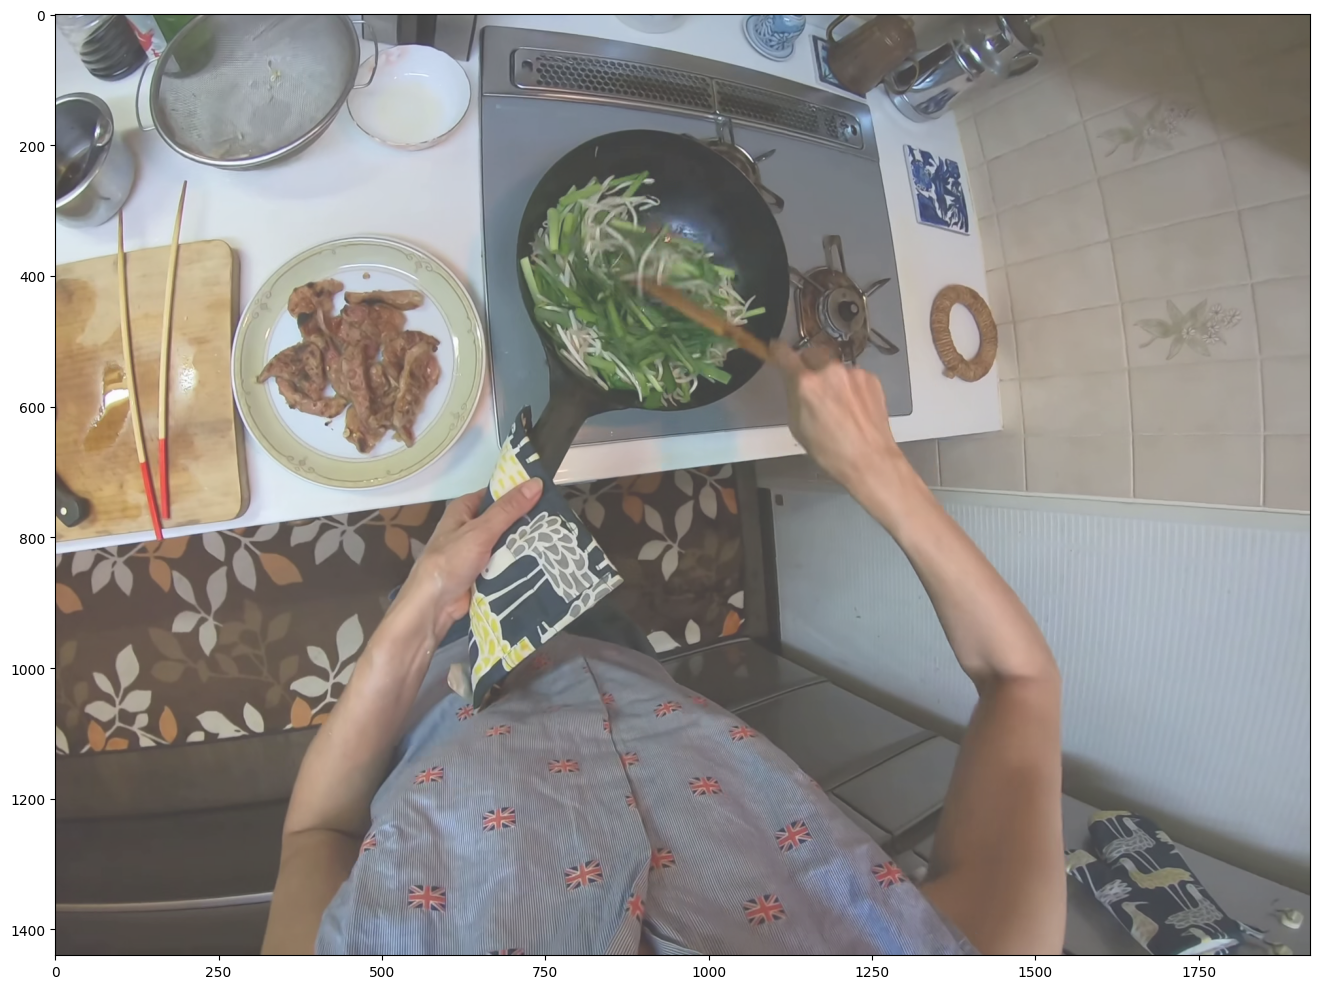

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.imshow(video_reader1[10], alpha=0.5)
ax.imshow(video_reader2[10], alpha=0.5)
plt.tight_layout()
plt.show()

In [69]:
full_scale_root = os.environ['EGO4D_VIDEOS_DIR']
clips_root = "/scratch/shared/beegfs/htd/DATA/ego4d/vq2d_5fps_libx264/"
my_clips_root = "/work/prannay/ego4d/vq2d_clips_val/"

In [70]:
with open("../data/val_annot.json", "r") as fp:
    annot = json.load(fp)

In [33]:
# annot['videos'][0]['clips']

In [34]:
# clip_uids = list(set([a['clip_uid'] for clip in annot['videos'] for a in clip['clips']]))

In [71]:
for a in annot:
    if a['clip_uid'] is None:
        print(a)

{'metadata': {'video_uid': 'd4c28488-a494-405d-bc8d-27a074aa9c5c', 'video_start_sec': 645.9876952666667, 'video_end_sec': 945.9543619333334, 'clip_fps': 5.0}, 'clip_uid': None, 'query_set': '1', 'query_frame': 578, 'response_track': [{'frame_number': 486, 'x': 272.35, 'y': -0.09, 'width': 64.93, 'height': 46.28, 'rotation': 0, 'original_width': 1440, 'original_height': 1080, 'video_frame_number': 22294}, {'frame_number': 487, 'x': 583.57, 'y': 16.14, 'width': 50.51, 'height': 76.37, 'rotation': 0, 'original_width': 1440, 'original_height': 1080, 'video_frame_number': 22300}, {'frame_number': 488, 'x': 723.79, 'y': 48.78, 'width': 37.89, 'height': 78.55, 'rotation': 0, 'original_width': 1440, 'original_height': 1080, 'video_frame_number': 22306}, {'frame_number': 489, 'x': 791.13, 'y': 111.92, 'width': 37.89, 'height': 78.55, 'rotation': 0, 'original_width': 1440, 'original_height': 1080, 'video_frame_number': 22312}, {'frame_number': 490, 'x': 762.12, 'y': 79.57, 'width': 35.19, 'heigh

In [35]:
clip_uids = list(set([ann['clip_uid'] for ann in annot]))

In [37]:
# for a in clip_uids:
#     if not isinstance(a, str):
#         print(a)
#         continue
#     if not os.path.isfile(os.path.join("/work/prannay/ego4d/vq2d_clips/", a + ".mp4")):
#         print(a)

In [45]:
FPS = 5
BUFFER_ABS = 1.0
BUFFER_REL = 0.2

In [46]:
end2query_frame = [(ann['query_frame'] - ann['response_track'][-1]['frame_number']) / float(FPS) for ann in annot]
print(np.mean(end2query_frame), np.std(end2query_frame))
print(np.median(end2query_frame))

15.939782560461506 36.778621773012084
5.0


In [39]:
clip_uid2annot = defaultdict(list)
for a in annot:
    clip_uid2annot[a['clip_uid']].append(a)

In [82]:
all_files = sorted(glob.glob("../data/clips/*.mp4"))
# only keep files which have not been modified in 10 minutes
print(len(all_files))
all_files = [f for f in all_files if os.stat(f).st_mtime < time.time() - 600]
print(len(all_files))

231
215


In [83]:
clips = list(map(os.path.basename, all_files))

In [84]:
to_do_annot = [a for clip in clips for a in clip_uid2annot[clip[:-4]]]
print(len(to_do_annot))

846


In [88]:
def extract_crop(ann):
    clip_uid = ann['clip_uid']
    crop_metadata = ann['visual_crop']
    video_path = os.path.join(my_clips_root, clip_uid + ".mp4")
    frame_id = crop_metadata['frame_number']
    with iio3.imopen(video_path, "r", plugin="pyav") as img_file:
        img = np.array(img_file.read(index=frame_id))
    x = crop_metadata['x']
    y = crop_metadata['y']
    w = crop_metadata['width']
    h = crop_metadata['height']
    x_, y_, w_, h_ = int(x // 1), int(y // 1), int(w // 1) + 1, int(h // 1) + 1
    x1_, y1_ = max(x_, 0), max(y_, 0)
    x2_, y2_ = min(x_ + w_, img.shape[1]), min(y_ + h_, img.shape[0])
    crop = img[y1_:y2_+1, x1_:x2_+1].copy()
    img_rect = cv2.rectangle(img, (x_, y_), (x2_, y2_), (255, 255, 0), 10)

    crop_filename = ann['dataset_uid'] + "_crop.jpg"
    crop_full_filename = os.path.join("../data/crops", crop_filename)

    img_filename = ann['dataset_uid'] + "_img.jpg"
    img_full_filename = os.path.join("../data/crops", img_filename)

    with open(crop_full_filename, "wb") as f:
        iio3.imwrite(f, crop, extension=".jpg")
    with open(img_full_filename, "wb") as f:
        iio3.imwrite(f, img_rect, extension=".jpg")

    # print(crop.shape, img_rect.shape)
    return

In [94]:
with Pool(4) as p:
    list(p.imap(extract_crop, tqdm(to_do_annot, total=len(to_do_annot))))

  0%|          | 0/846 [00:00<?, ?it/s]

In [74]:
clip_uid2annot[clips[0][:-4]]['response_track']

[{'frame_number': 400,
  'x': 1785.51,
  'y': 0.25,
  'width': 130.92,
  'height': 340.67,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1440,
  'video_frame_number': 15900},
 {'frame_number': 401,
  'x': 1623.88,
  'y': 0.25,
  'width': 304.04,
  'height': 329.12,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1440,
  'video_frame_number': 15906},
 {'frame_number': 402,
  'x': 1446.84,
  'y': 0.25,
  'width': 384.86,
  'height': 344.52,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1440,
  'video_frame_number': 15912},
 {'frame_number': 403,
  'x': 1335.23,
  'y': -9.3,
  'width': 327.13,
  'height': 365.61,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1440,
  'video_frame_number': 15918},
 {'frame_number': 404,
  'x': 1300.6,
  'y': 0.25,
  'width': 323.28,
  'height': 321.42,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1440,
  'video_frame_number': 15924},
 {'frame_number': 405,
  'x': 1285.2

In [103]:
def resize_image(img, shortest_side, max_long_side):
    h, w = img.shape[:2]
    if h < w:
        new_h = shortest_side
        new_w = int(w * (shortest_side / h))
    else:
        new_w = shortest_side
        new_h = int(h * (shortest_side / w))
    if new_w > max_long_side:
        new_w = max_long_side
        new_h = int(h * (max_long_side / w))
    elif new_h > max_long_side:
        new_h = max_long_side
        new_w = int(w * (max_long_side / h))
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    return resized_img

In [106]:
def process_clip(ann, use_abs_buffer=True, write_gif=False, use_iio3=True):
    clip_uid = ann['clip_uid']
    clip_path = os.path.join(my_clips_root, clip_uid + ".mp4")
    with open(clip_path, "rb") as fp:
        meta = iio3.immeta(fp, extension=".mp4", plugin="pyav")
        num_frames = int(meta['fps'] * meta['duration'])
    min_frame_id = 0
    max_frame_id = num_frames - 1
    ann_max_frame = ann['response_track'][-1]['frame_number']
    ann_min_frame = ann['response_track'][0]['frame_number']
    if use_abs_buffer:
        start_frame = max(min_frame_id, ann_min_frame - BUFFER_ABS * FPS)
        end_frame = min(max_frame_id, max(ann['query_frame'], ann_max_frame + BUFFER_ABS * FPS))
    else:
        start_frame = max(min_frame_id, ann_min_frame - BUFFER_REL * (ann_max_frame - ann_min_frame))
        end_frame = min(max_frame_id, max(ann['query_frame'], ann_max_frame + BUFFER_REL * (ann_max_frame - ann_min_frame)))

    start_frame = int(start_frame)
    end_frame = int(end_frame)

    print(ann_min_frame, ann_max_frame, ann['query_frame'])

    print(start_frame, ann_min_frame)
    print(end_frame, ann_max_frame)

    frame_num = start_frame
    bbox_offset_start = start_frame - ann_min_frame
    bbox_offset_end = ann_max_frame - ann_min_frame
    print(bbox_offset_start)

    crop_path = os.path.join("../data/crops/", ann['dataset_uid'] + "_crop.jpg")
    with open(crop_path, "rb") as fp:
        crop = iio3.imread(fp, extension=".jpg")
    crop = resize_image(crop, 256, 512)

    if not write_gif:
        return
    gif_writer = iio.get_writer(os.path.join("../data/gifs/", ann['dataset_uid'] + ".gif"), mode="I", fps=float(FPS))

    if use_iio3:
        with iio3.imopen(clip_path, "r", plugin="pyav") as img_reader:
            for offset, frame_id in enumerate(range(start_frame, end_frame+1), start=bbox_offset_start):
                img = img_reader.read(index=frame_id)
                img[:crop.shape[0], :crop.shape[1]] = crop
                if offset >= 0 and offset <= bbox_offset_end:
                    x, y, w, h = (
                        ann['response_track'][offset]['x'],
                        ann['response_track'][offset]['y'],
                        ann['response_track'][offset]['width'],
                        ann['response_track'][offset]['height'],
                    )
                    x, y, w, h = int(x), int(y), int(w) + 1, int(h) + 1
                    img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 0), 10)
                elif frame_id == ann['query_frame']:
                    x1, y1, x2, y2 = 0, 0, img.shape[1], img.shape[0]
                    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 255), 10)
                # add crop to top left of image
                
                gif_writer.append_data(img)
    else:
        ## OpenCV
        vid = cv2.VideoCapture(clip_path)
        for offset, frame_id in enumerate(range(start_frame, end_frame+1), start=bbox_offset_start):
            vid.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
            ret, img = vid.read()
            assert ret
            if offset >= 0 and offset <= bbox_offset_end:
                x, y, w, h = (
                    ann['response_track'][offset]['x'],
                    ann['response_track'][offset]['y'],
                    ann['response_track'][offset]['width'],
                    ann['response_track'][offset]['height'],
                )
                x, y, w, h = int(x), int(y), int(w) + 1, int(h) + 1
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 0), 10)
            elif frame_id == ann['query_frame']:
                x1, y1, x2, y2 = 0, 0, img.shape[1], img.shape[0]
                img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 255), 10)

    gif_writer.append_data(np.zeros_like(img))
    gif_writer.close()
    return
    # vid.release()


In [108]:
clips = ["46f81889-4ace-4978-98bf-a5d711ecdd01.mp4", "c8070026-c3dc-43d3-8d36-65c5d9a1317f.mp4", "38aa2951-379c-48bd-b0fe-17cce2bb27bf.mp4"]
for clip in clips:
    process_clip(clip_uid2annot[clip[:-4]][-1], write_gif=True, use_iio3=True)

/users/prannay/miniconda3/envs/vq2d_dev/lib/python3.8/site-packages/imageio/plugins/pyav.py:731: UserWarning: PyAV 10.0.0 has known issues reading metadata. If you need video metadata consider using v9.2.0 instead.
  warnings.warn(


178 178 195
173 178
195 178
-5
(190, 138, 3)
1472 1475 1491
1467 1472
1491 1475
-5
(29, 31, 3)
1335 1344 1359
1330 1335
1359 1344
-5
(117, 71, 3)


In [64]:
query_clip = "38aa2951-379c-48bd-b0fe-17cce2bb27bf.mp4"[:-4]
query_ann = clip_uid2annot[query_clip][0]
query_path_full_scale = os.path.join(full_scale_root, query_ann["metadata"]['video_uid'] + ".mp4")
query_path_tengda = os.path.join(clips_root, query_clip + ".mp4")
query_path_mine = os.path.join(my_clips_root, query_clip + ".mp4")

In [65]:
print(query_path_full_scale)
print(query_path_tengda)
print(query_path_mine)

/scratch/shared/beegfs/shared-datasets/EGO4D/ego4d_data/v1/full_scale/d37e336e-31b7-464f-bc74-f836279dcee3.mp4
/scratch/shared/beegfs/htd/DATA/ego4d/vq2d_5fps_libx264/38aa2951-379c-48bd-b0fe-17cce2bb27bf.mp4
/work/prannay/ego4d/vq2d_clips_val/38aa2951-379c-48bd-b0fe-17cce2bb27bf.mp4


In [66]:
visual_crop = query_ann['visual_crop']
visual_crop

{'frame_number': 3,
 'x': 1244.3,
 'y': 95.75,
 'width': 146.02,
 'height': 218.94,
 'rotation': 0,
 'original_width': 1440,
 'original_height': 1080,
 'video_frame_number': 17}

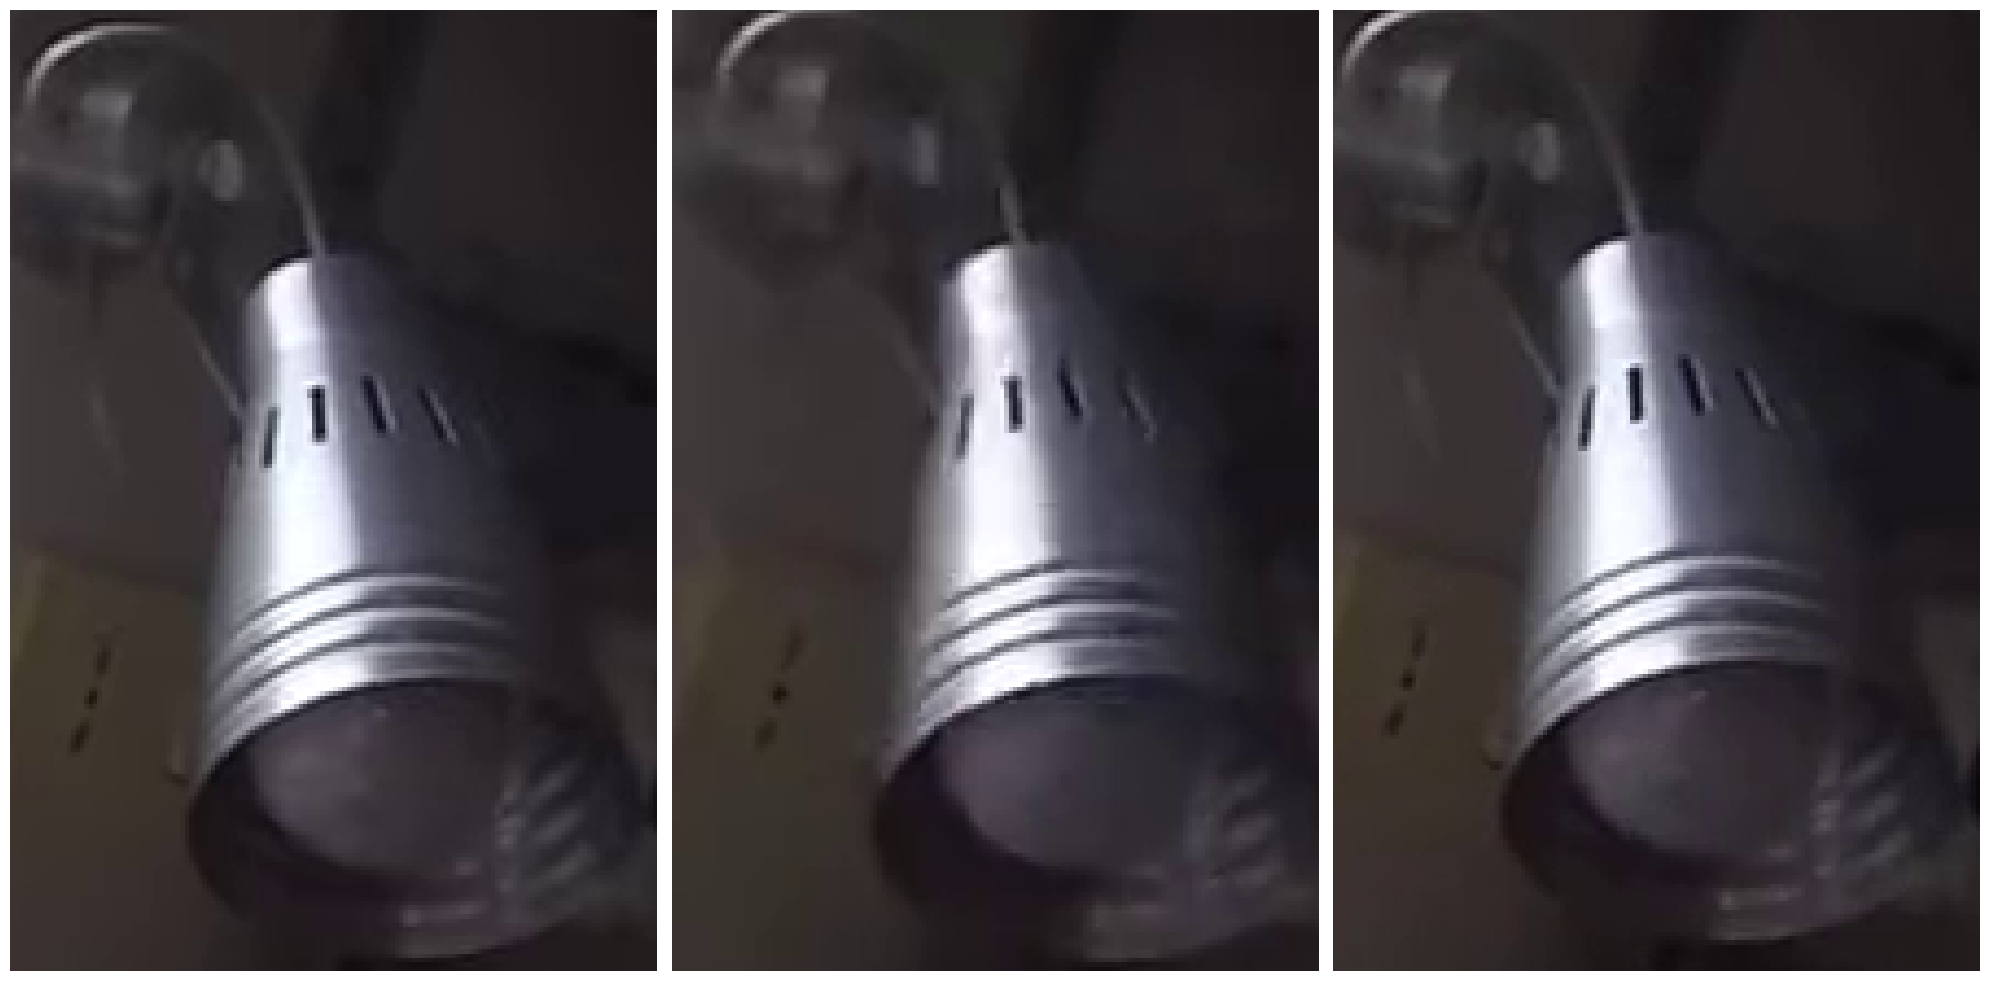

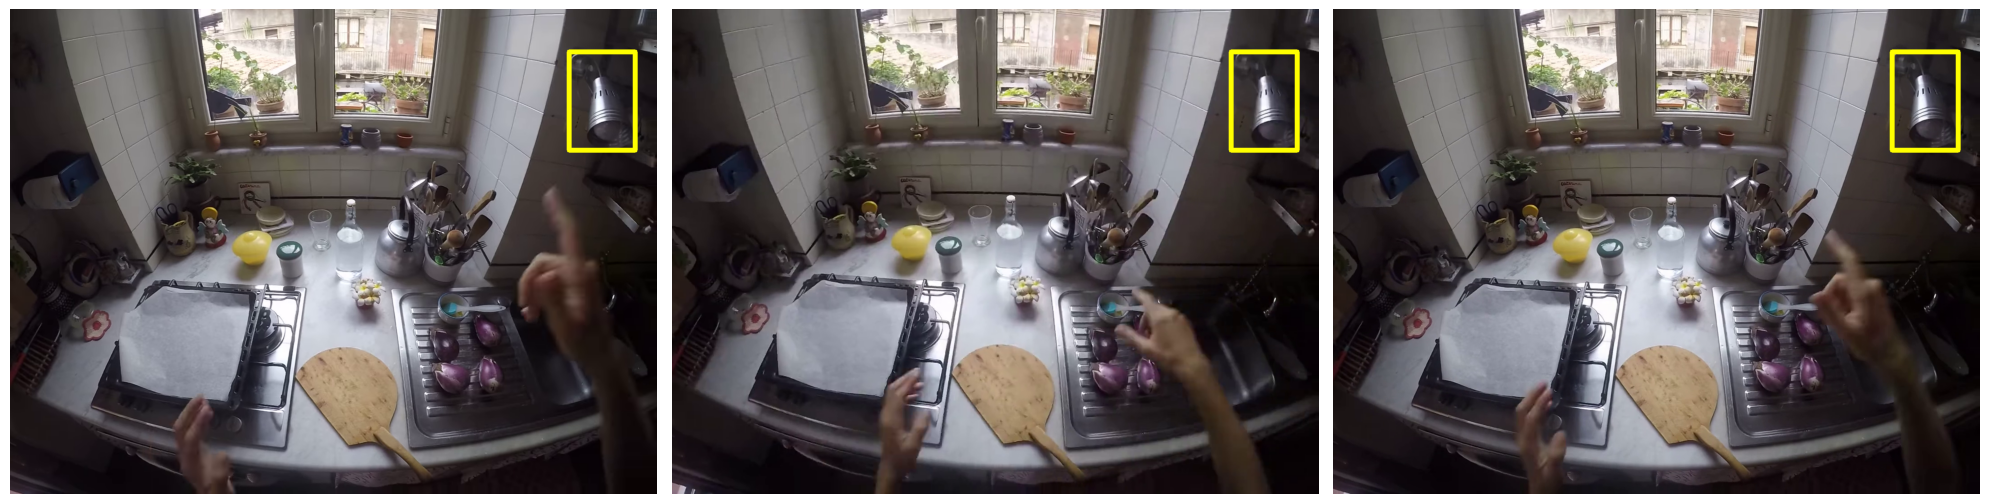

In [67]:
## full_scale extract frame
with iio.imopen(query_path_full_scale, "r", plugin="pyav") as img_file:
    query_frame_full = np.array(img_file.read(index=visual_crop['video_frame_number']))

## tengda extract frame
with iio.imopen(query_path_tengda, "r", plugin="pyav") as img_file:
    query_frame_tengda = np.array(img_file.read(index=visual_crop['frame_number']))

## mine extract frame
with iio.imopen(query_path_mine, "r", plugin="pyav") as img_file:
    query_frame_mine = np.array(img_file.read(index=visual_crop['frame_number']))

## extract crop from the frame
def extract_crop(frame, visual_crop):
    x, y, w, h = visual_crop['x'], visual_crop['y'], visual_crop['width'], visual_crop['height']
    x, y, w, h = int(x), int(y), int(w) + 1, int(h) + 1
    return frame[y:y+h+1, x:x+w+1].copy()

## add rectangle to each frame
def add_rect(frame, visual_crop):
    x, y, w, h = visual_crop['x'], visual_crop['y'], visual_crop['width'], visual_crop['height']
    x, y, w, h = int(x), int(y), int(w) + 1, int(h) + 1
    frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 0), 10)
    return frame

query_crop_full = extract_crop(query_frame_full, visual_crop)
query_crop_tengda = extract_crop(query_frame_tengda, visual_crop)
query_crop_mine = extract_crop(query_frame_mine, visual_crop)

query_frame_full = add_rect(query_frame_full, visual_crop)
query_frame_tengda = add_rect(query_frame_tengda, visual_crop)
query_frame_mine = add_rect(query_frame_mine, visual_crop)

## plot crops
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for a in ax.ravel():
    a.set_axis_off()
ax[0].imshow(query_crop_full)
ax[1].imshow(query_crop_tengda)
ax[2].imshow(query_crop_mine)
plt.tight_layout()
plt.show()


## plot frames
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for a in ax.ravel():
    a.set_axis_off()
ax[0].imshow(query_frame_full)
ax[1].imshow(query_frame_tengda)
ax[2].imshow(query_frame_mine)
plt.tight_layout()
plt.show()

In [4]:
# len(set([a['clip_uid'] for a in annot]))

In [ ]:
diff_frames = []
for ann in annot:
    diff_frames.append((ann['response_track'][-1]['video_frame_number'] - ann['response_track'][0]['video_frame_number']) / 30)